## Download dataset

In [1]:
# method1. upload dataset manually (very slow)
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# method 2. faster way using kaggle command ( please check https://www.kaggle.com/general/74235)

#1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

#2. Click on Create New API Token - It will download kaggle.json file on your machine.

#3. Go to your Google Colab project file and run the following commands:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# unzip dataset
!kaggle competitions download -c computer-vision-hw4
!unzip computer-vision-hw4.zip 
!ls -alh

串流輸出內容已截斷至最後 5000 行。
  inflating: ccpd6000/test_images/1009.jpg  
  inflating: ccpd6000/test_images/1010.jpg  
  inflating: ccpd6000/test_images/1011.jpg  
  inflating: ccpd6000/test_images/1012.jpg  
  inflating: ccpd6000/test_images/1013.jpg  
  inflating: ccpd6000/test_images/1014.jpg  
  inflating: ccpd6000/test_images/1015.jpg  
  inflating: ccpd6000/test_images/1016.jpg  
  inflating: ccpd6000/test_images/1017.jpg  
  inflating: ccpd6000/test_images/1018.jpg  
  inflating: ccpd6000/test_images/1019.jpg  
  inflating: ccpd6000/test_images/1020.jpg  
  inflating: ccpd6000/test_images/1021.jpg  
  inflating: ccpd6000/test_images/1022.jpg  
  inflating: ccpd6000/test_images/1023.jpg  
  inflating: ccpd6000/test_images/1024.jpg  
  inflating: ccpd6000/test_images/1025.jpg  
  inflating: ccpd6000/test_images/1026.jpg  
  inflating: ccpd6000/test_images/1027.jpg  
  inflating: ccpd6000/test_images/1028.jpg  
  inflating: ccpd6000/test_images/1029.jpg  
  inflating: ccpd6000/test_images/

In [4]:
# !sudo kill -9 0
!nvidia-smi


Sun Dec 18 08:41:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import torch

print(torch.cuda.is_available())

print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))


True
1
0
Tesla T4


In [6]:
import warnings

import torch
import numpy as np
from PIL import Image, ImageDraw
from skimage import util
from skimage.transform import ProjectiveTransform, warp

def draw_kpts(img, kpts, c='red', r=2.0):
    '''Draw keypoints on image.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
        c: (PIL.Color) color of keypoints, default to 'red'
        r: (float) radius of keypoints, default to 2.0
    Return:
        img: (PIL.Image) modified image
    '''
    draw = ImageDraw.Draw(img)
    kpts = kpts.view(4, 2)
    kpts = kpts * torch.FloatTensor(img.size)
    kpts = kpts.numpy().tolist()
    for (x, y) in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img


def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

# Init and Utility

In [7]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

import torch.optim
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [8]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

# Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


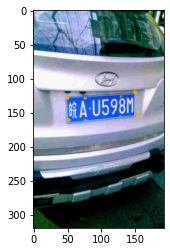

In [9]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img_path = self.img_paths[idx]

        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        
        # parse annotation
        kpt = self.anns[idx]
        kpt = list(kpt.values())[1:9]
        kpt = torch.tensor(kpt) # [8,]
        kpt = kpt.view(4, 2) # [4, 2]
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1) # [8,]
        
        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

# Network

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary

        # TODO : add more layers to achieve better performance
        # (3,320,192)
        # self.features = Conv2d(3, 64, 3, 1, 1)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 320, 192]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 160, 96]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 160, 96]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 80, 48]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 80, 48]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 40, 24]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 40, 24]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 20, 12]
            
            nn.Conv2d(512, 1024, 3, 1, 1), # [1024, 20, 12]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [1024, 10, 6]
            # nn.AdaptiveMaxPool2d
            
            nn.Conv2d(1024, 512, 3, 1, 1), # [512, 10, 6]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 5, 3]
        )
        # TODO : add ouput layer to predict position
        # self.regression = nn.ReLU()
        self.regression = nn.Sequential(
            # nn.Flatten(),
            # nn.Dropout(0.5),
            nn.Linear(512*5*3, 1024),
            # nn.Linear(6, 1024),
            nn.ReLU(),
            
            # nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, 8),
            # nn.ReLU(),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.Linear(128, 8),
        )
        
        # self.conv_1 = nn.Conv2d(3, output_channel, 3)
        # nn.Conv2d(3, 64, 3, 1, 1)
        # self.relu_1 = nn.ReLU()

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        features = self.features(img_b)
        # 163840x6 and 8192x1024)
        features = features.view(features.size()[0], -1)
        kpt_b = self.regression(features)
      
        return kpt_b



In [11]:
# model = Net().cuda()
# loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
# num_epoch = 30

In [12]:
"""
清理內存
"""
import torch
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()

2489

In [13]:
# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]
print(kpt_b[0]) 

# Do a forwarding
# device = 'gpu'     # the computing device, 'cuda' or 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)

pred_b = model(img_b)
print(pred_b.size())
loss = criterion(pred_b, kpt_b)
print(pred_b)
print(loss)

torch.Size([32, 3, 320, 192])
torch.Size([32, 8])
tensor([0.5181, 0.4871, 0.1833, 0.4474, 0.1750, 0.3862, 0.5097, 0.4259])
torch.Size([32, 8])
tensor([[-0.0428, -0.0787, -0.1010, -0.0476,  0.0461,  0.0072, -0.0843,  0.0008],
        [-0.0768,  0.0004, -0.0419,  0.0058,  0.0441,  0.0566, -0.0092,  0.0681],
        [-0.0624, -0.0409, -0.0982, -0.0252,  0.0651,  0.0063, -0.0246,  0.0695],
        [-0.1296, -0.1118, -0.0202, -0.0360,  0.0355, -0.0356, -0.0114, -0.0327],
        [-0.0975, -0.1011, -0.0242, -0.0521, -0.0028,  0.0940,  0.0091, -0.0195],
        [-0.1584, -0.0620, -0.1241, -0.0439,  0.0421,  0.0635, -0.0926, -0.0151],
        [-0.1410, -0.0826, -0.0946, -0.0640,  0.0384,  0.0112, -0.0086,  0.0309],
        [-0.2659, -0.0690, -0.1710, -0.1422,  0.1260,  0.0775,  0.0005,  0.0449],
        [-0.1358, -0.0087, -0.0843, -0.0789,  0.0390, -0.0500,  0.0270, -0.0132],
        [-0.0679, -0.0716, -0.0947, -0.0833,  0.0741,  0.0224, -0.0560,  0.0242],
        [-0.0710, -0.0718, -0.1053, -

In [14]:
# model = Net().to(device)
# criterion = nn.L1Loss()  
print(model)


Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# Training

In [15]:
from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# model = resnet50(weights="IMAGENET1K_V1")
model = resnet50(pretrained=True)  # deprecated
model = resnet50(True)  # deprecated

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


lr: 0.0009
Epoch 000:
train loss: 0.12161306093136469
valid loss: 0.04243882484734059
train mse: 0.163063310085757
valid mse: 0.003293751700160404
lr: 0.0009
Epoch 001:
train loss: 0.04647686028232177
valid loss: 0.04697120661536853
train mse: 0.0036794989772412617
valid mse: 0.0035038727743085473
lr: 0.0009
Epoch 002:
train loss: 0.03454933329485357
valid loss: 0.025968695835520823
train mse: 0.0020588729485704485
valid mse: 0.0013063902753250054
lr: 0.0009
Epoch 003:
train loss: 0.033368391023638345
valid loss: 0.04020634132126967
train mse: 0.0019410658374302632
valid mse: 0.0024903985788114367
lr: 0.0009
Epoch 004:
train loss: 0.029367405668987583
valid loss: 0.02444390906020999
train mse: 0.0015140411154182705
valid mse: 0.0011225836400020246
lr: 0.0009
Epoch 005:
train loss: 0.026740712734560173
valid loss: 0.026389739538232485
train mse: 0.0012726519911666402
valid mse: 0.0012444660242181271
lr: 0.0009
Epoch 006:
train loss: 0.02648879582217584
valid loss: 0.020779473319028813
t

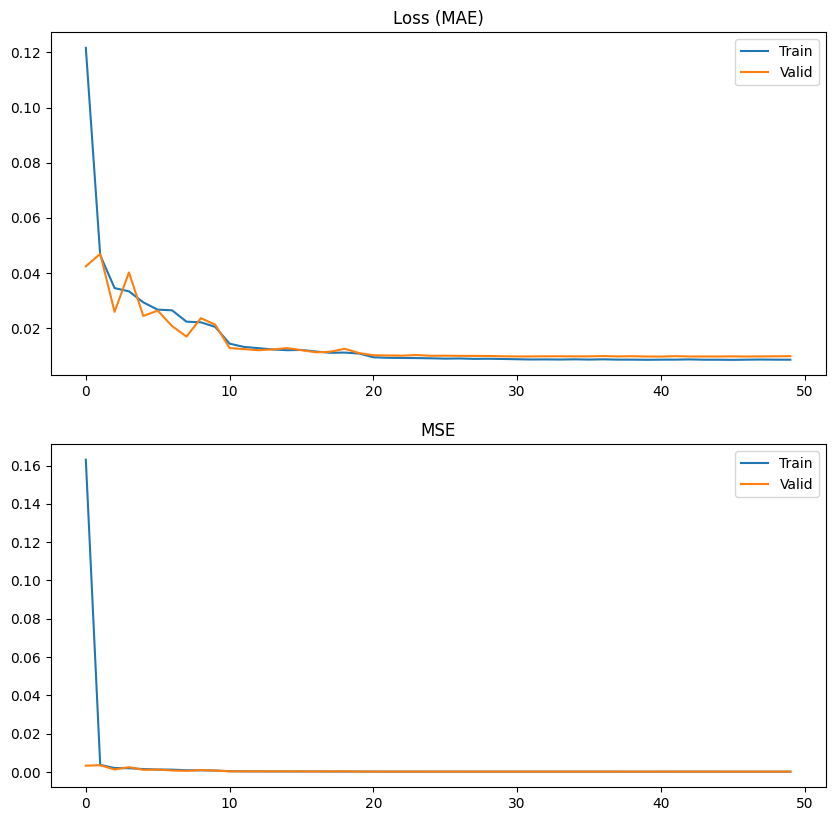

In [16]:
import torch.optim.lr_scheduler
import os

class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.model = Net().to(self.device)
        # self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        # self.model = resnet50(weights="IMAGENET1K_V1")
        # self.model = resnet50(pretrained=True)  # deprecated
        # self.model = resnet50(True).to(self.device)  # deprecated
        
        # resnet50(weights=None)
        # resnet50()
        # resnet50(pretrained=False)  # deprecated
        # resnet50(False)  # deprecated

        self.criterion = nn.L1Loss()
        # self.criterion = nn.MSELoss()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=9e-4)
        # self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.0009)#, momentum=0.9

        # self.scheduler = ExponentialLR(self.optimizer, gamma=0.9)
        # self.scheduler = ExponentialLR(self.optimizer, gamma=0.9, last_epoch=self.max_epoch)
        # self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)
        
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer,step_size=10,gamma=0.1,last_epoch=-1)
        # self.scheduler = torch.optim.lr_scheduler.LinearLR(self.optimizer, start_factor=0.5, total_iters= 5)
        
        
        
        # torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)

        # optimizer = optim.SGD(net.parameters(), lr = 1e-5)
        # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15], gamma=0.1)
        # scheduler.step()

    
        #TODO define your training epochs
        self.max_epoch = 50

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': [], 'train_mse': [], 'valid_mse': []}

        for self.epoch in range(self.max_epoch): # epochs
            train_loss, train_mse = self.train() # train 1 epoch
            valid_loss, valid_mse = self.valid() # valid 1 epoch
            self.visul()              # visualization
            print('lr:',get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            print('train mse:', train_mse)
            print('valid mse:', valid_mse)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            metrics['train_mse'].append(train_mse)
            metrics['valid_mse'].append(valid_mse)
            # Save the parameters(weights) of the model to disk
            # if torch.tensor(metrics['valid_mse']).argmin() == self.epoch:
            # if (torch.tensor(metrics['valid_mse']).argmin()%10==0):
            #     torch.save(self.model.state_dict(), str(training_result_dir/ 'model.pth'))

                # torch.save(self.model.state_dict(), str(training_result_dir/ 'model.pth'))

            torch.save(self.model.state_dict(), os.path.join(training_result_dir, 'model-{}.pth'.format(self.epoch)))
        # self.scheduler.step()
            

        # Plot the loss curve against epoch
        fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
        ax[0].set_title('Loss (MAE)')
        ax[0].plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax[0].plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax[0].legend()
        ax[1].set_title('MSE')
        ax[1].plot(range(self.epoch + 1), metrics['train_mse'], label='Train')
        ax[1].plot(range(self.epoch + 1), metrics['valid_mse'], label='Valid')
        ax[1].legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.train_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            
            self.optimizer.zero_grad()
            pred_b = self.model(img_b)
            
            # TODO 
            # step 1 caculate the loss 
            loss = self.criterion(pred_b, kpt_b)
            #Replaces pow(2.0) with abs() for L1 regularization
     
            """
            loss 
            """
            # l2_lambda = 0.001
            # l2_norm = sum(p.pow(2.0).sum()
            #       for p in model.parameters())
 
            # loss = loss + l2_lambda * l2_norm

            # step 2 back propagation
            loss.backward()
            # batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
            # step 3 update parameters using optimizer
            self.optimizer.step() # 以 optimizer 用 gradient 更新參數值
            
            

            loss_steps.append(loss.detach().item())
            mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mse_steps.append(mse)
        
        self.scheduler.step()
        
        avg_loss = sum(loss_steps) / len(loss_steps)
        avg_mse = sum(mse_steps) / len(mse_steps)
        return avg_loss, avg_mse

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss_steps.append(loss.detach().item())
            mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mse_steps.append(mse)

        avg_loss = sum(loss_steps) / len(loss_steps)
        avg_mse = sum(mse_steps) / len(mse_steps)
        return avg_loss, avg_mse

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

# Testing

In [18]:
# Do testing
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import utils
#from utils.model import CCPDRegressor
img_size=(192, 320)
class CCPDTest:
    def __init__(self, img_dir):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./ccpd6000/test_images')
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

device = 'cuda'
model = Net().to(device)
# model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))

model.load_state_dict(torch.load(str(log_dir / 'training_result/model-49.pth')))

# model.state_dict(), os.path.join(training_result_dir, 'model-{}.pth'.format(self.epoch)))


# model.load_state_dict(torch.load('runs/Jan.14 11:12:28/training_result/model.pth'))
model.eval()

log_dir_test = Path('./testing_result') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

def test(pbar):
    model.eval()
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir_test / f'{pbar.n:03d}_vis.jpg')
            # Original image size: 720 * 1160
            # print(kpt)
            # print(kpt[0:-1:2])
            # print(kpt[1::2])
            kpt[0:-1:2] *= 720
            kpt[1::2] *= 1160
            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()

    return pd.DataFrame(anns)

with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv('./ccpd6000/test_pred.csv', float_format='%.5f', index=False)

testing_result/Dec.18 09:28:56


100%|██████████| 3000/3000 [01:19<00:00, 37.92it/s]


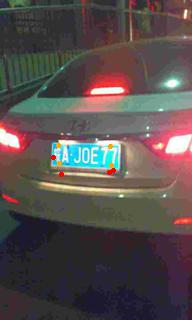

In [19]:
display.Image(str(log_dir / '001' / '026.jpg')) # A visualization of validation data in epoch 4

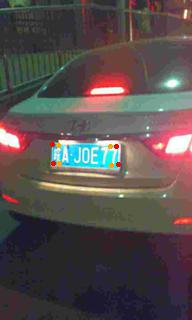

In [20]:
display.Image(str(log_dir / '049' / '026.jpg')) # A visualization of validation data in epoch 10

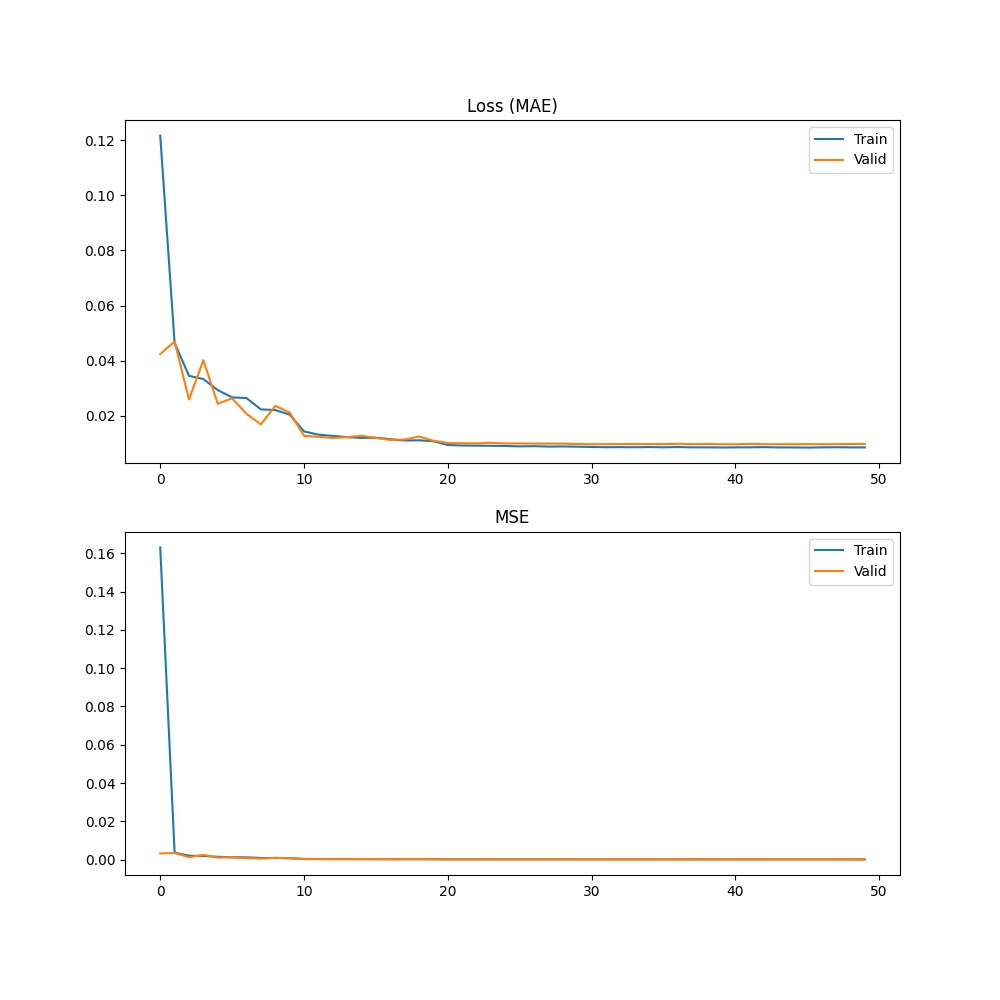

In [21]:
display.Image(str(log_dir / 'training_result/metrics.jpg')) # Loss

In [ ]:
!ls


In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Report

## 方法
- learning rate :使用 StepLR 每10 epoch LR＊0.1,嘗試各種LR schedule 方法發現StepLR 最好用
- epoch:儲存每一個epoch訓練10/30/50次數取valid mse 最好的做做test
- loss:使用L1loss為最好的,嘗試過mseloss,loss+L2正則化 
- 架構：選擇刻 vgg 架構在稍微多幾層 conv , 嘗試使用renet18 50等等pretrain model 效果調整參數後 沒有得到較好結果
- optimizer:使用使用adam,調整參數為最佳,ＳＧＤ方法未找到更好結果